# Exploratory Data Analysis (EDA)

In [1]:
# Name: Anthony Tan Beng Wah   NRIC: 095C
# Import the requried packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import requests
import os
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model, neighbors, tree, svm, ensemble, neural_network
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate

# Data Retrieval from Database

In [2]:
# URL of the SQLite database
url = "https://techassessment.blob.core.windows.net/aiap19-assessment-data/agri.db"
file_name = "agri.db"

# Download the file from the URL
if not os.path.exists(file_name):  # Check if the file is already downloaded
    print(f"Downloading {file_name}...")
    response = requests.get(url)
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print("Download complete.")

# Connect to the SQLite database
conn = sqlite3.connect(file_name)

# List tables in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)
print("Tables in the database:")
print(tables)

# Read data from farm_data table and load into agri dataframe
table_name = "farm_data"  # Replace with the table name you want to query
agri = pd.read_sql_query(f"SELECT * FROM {"farm_data"};", conn)

# Display the first 5 rows of data
print(agri.head())

Tables in the database:
        name
0  farm_data
  System Location Code Previous Cycle Plant Type           Plant Type  \
0               Zone_D                     Herbs           Vine Crops   
1               Zone_G                     Herbs           VINE CROPS   
2               Zone_F                     Herbs                herbs   
3               Zone_G                     Herbs  fruiting vegetables   
4               Zone_B                Vine Crops         LEAFY GREENS   

  Plant Stage  Temperature Sensor (°C)  Humidity Sensor (%)  \
0    Maturity                    23.34                  NaN   
1  Vegetative                   -24.16                63.14   
2    maturity                    23.84                  NaN   
3  Vegetative                    22.61                  NaN   
4    seedling                    22.88                  NaN   

   Light Intensity Sensor (lux)  CO2 Sensor (ppm)  EC Sensor (dS/m)  \
0                         454.0               937            

In [3]:
# display the datatype of agri db attributes
agri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          57489 non-null  object 
 1   Previous Cycle Plant Type     57489 non-null  object 
 2   Plant Type                    57489 non-null  object 
 3   Plant Stage                   57489 non-null  object 
 4   Temperature Sensor (°C)       48800 non-null  float64
 5   Humidity Sensor (%)           18622 non-null  float64
 6   Light Intensity Sensor (lux)  53211 non-null  float64
 7   CO2 Sensor (ppm)              57489 non-null  int64  
 8   EC Sensor (dS/m)              57489 non-null  float64
 9   O2 Sensor (ppm)               57489 non-null  int64  
 10  Nutrient N Sensor (ppm)       47515 non-null  object 
 11  Nutrient P Sensor (ppm)       51791 non-null  object 
 12  Nutrient K Sensor (ppm)       53788 non-null  object 
 13  p

In [4]:
# check for columns with null value
agri.isnull().sum()

System Location Code                0
Previous Cycle Plant Type           0
Plant Type                          0
Plant Stage                         0
Temperature Sensor (°C)          8689
Humidity Sensor (%)             38867
Light Intensity Sensor (lux)     4278
CO2 Sensor (ppm)                    0
EC Sensor (dS/m)                    0
O2 Sensor (ppm)                     0
Nutrient N Sensor (ppm)          9974
Nutrient P Sensor (ppm)          5698
Nutrient K Sensor (ppm)          3701
pH Sensor                           0
Water Level Sensor (mm)          8642
dtype: int64

# Data Cleansing

In [5]:
# Data Cleansing
# Remove 'ppm' from the nutrient_n, nutrient_p and nutrient_k columns and then convert these 3 columns to float data type
agri['Nutrient N Sensor (ppm)'] = agri['Nutrient N Sensor (ppm)'].str.replace('ppm', '', regex=False).str.strip()
agri['Nutrient N Sensor (ppm)'] = agri['Nutrient N Sensor (ppm)'].astype(float)
agri['Nutrient P Sensor (ppm)'] = agri['Nutrient P Sensor (ppm)'].str.replace('ppm', '', regex=False).str.strip()
agri['Nutrient P Sensor (ppm)'] = agri['Nutrient P Sensor (ppm)'].astype(float)
agri['Nutrient K Sensor (ppm)'] = agri['Nutrient K Sensor (ppm)'].str.replace('ppm', '', regex=False).str.strip()
agri['Nutrient K Sensor (ppm)'] = agri['Nutrient K Sensor (ppm)'].astype(float)


# Replace NaN values with the median value of the column
agri['Nutrient N Sensor (ppm)'] = agri['Nutrient N Sensor (ppm)'].fillna(agri['Nutrient N Sensor (ppm)'].median())
agri['Nutrient P Sensor (ppm)'] = agri['Nutrient P Sensor (ppm)'].fillna(agri['Nutrient P Sensor (ppm)'].median())
agri['Nutrient K Sensor (ppm)'] = agri['Nutrient K Sensor (ppm)'].fillna(agri['Nutrient K Sensor (ppm)'].median())
agri['Temperature Sensor (°C)'] = agri['Temperature Sensor (°C)'].fillna(agri['Temperature Sensor (°C)'].median())
agri['Humidity Sensor (%)'] = agri['Humidity Sensor (%)'].fillna(agri['Humidity Sensor (%)'].median())
agri['Light Intensity Sensor (lux)'] = agri['Light Intensity Sensor (lux)'].fillna(agri['Light Intensity Sensor (lux)'].median())
agri['Water Level Sensor (mm)'] = agri['Water Level Sensor (mm)'].fillna(agri['Water Level Sensor (mm)'].median())

agri.head(20)

,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
0,Zone_D,Herbs,Vine Crops,Maturity,23.34,68.70,454.0,937,1.82,4,161.0,64.0,201.0,6.1,28.150346
1,Zone_G,Herbs,VINE CROPS,Vegetative,-24.16,63.14,441.0,938,2.13,6,161.0,53.0,215.0,6.5,31.000000
2,Zone_F,Herbs,herbs,maturity,23.84,68.70,562.0,1246,1.21,8,228.0,79.0,292.0,6.4,26.000000
3,Zone_G,Herbs,fruiting vegetables,Vegetative,22.61,68.70,651.0,1346,1.96,6,158.0,53.0,289.0,6.6,26.000000
4,Zone_B,Vine Crops,LEAFY GREENS,seedling,22.88,68.70,144.0,812,2.76,5,61.0,19.0,168.0,5.5,28.000000
5,Zone_C,Vine Crops,FRUITING VEGETABLES,MATURITY,25.96,68.70,675.0,1338,1.75,8,227.0,53.0,258.0,6.2,23.092135
6,Zone_A,Leafy Greens,Vine Crops,Maturity,23.21,68.70,514.0,1103,1.14,8,174.0,62.0,217.0,5.5,35.000000
7,Zone_G,Herbs,Leafy Greens,Maturity,20.16,68.70,317.0,1133,1.52,10,158.0,50.0,277.0,5.8,39.611156
8,Zone_G,Herbs,Leafy Greens,Maturity,20.16,68.70,317.0,1133,1.52,10,158.0,50.0,277.0,5.8,39.611156
9,Zone_B,Vine Crops,Vine Crops,MATURITY,25.59,68.70,435.0,845,2.07,8,150.0,70.0,210.0,5.3,27.835062


In [6]:
agri.isnull().sum()  # check to confirm no more null value

System Location Code            0
Previous Cycle Plant Type       0
Plant Type                      0
Plant Stage                     0
Temperature Sensor (°C)         0
Humidity Sensor (%)             0
Light Intensity Sensor (lux)    0
CO2 Sensor (ppm)                0
EC Sensor (dS/m)                0
O2 Sensor (ppm)                 0
Nutrient N Sensor (ppm)         0
Nutrient P Sensor (ppm)         0
Nutrient K Sensor (ppm)         0
pH Sensor                       0
Water Level Sensor (mm)         0
dtype: int64

In [7]:
# Column values to convert to lowercase for Plant Type and Plant Stage for consistency in data analytics and predictions
agri['Plant Type'] = agri['Plant Type'].str.lower()
agri['Plant Stage'] = agri['Plant Stage'].str.lower()


# Exploratory Data Analytics (EDA)

1a. Mean Temperature, Humidity, Light Intensity, pH and Water Level by Zone 

This is to compare the different environmental requirements by the different zones.
The average temperature, humidity, pH and water level do not differ much between the 7 zones.  However, there is a slightly higher light intensity required for Zone F.

In [8]:
mean_temp = agri[['Temperature Sensor (°C)', 'Humidity Sensor (%)','Light Intensity Sensor (lux)','pH Sensor','Water Level Sensor (mm)']].groupby(agri['System Location Code'])
mean_temp.mean()

,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),pH Sensor,Water Level Sensor (mm)
System Location Code,,,,,
Zone_A,22.251112,68.858015,399.552774,6.015734,25.777582
Zone_B,22.270552,68.905451,394.162006,6.015947,25.747574
Zone_C,22.305547,68.899675,398.779149,6.020102,25.654610
Zone_D,22.192231,68.813236,397.375217,6.026867,25.809363
Zone_E,22.392051,68.835423,395.262331,6.018677,25.823049
Zone_F,22.302131,68.899674,403.198504,6.028298,25.797937
Zone_G,22.384223,68.919283,399.326777,6.024653,25.708110


1b. Mean Carbon Dioxide, Oxygen, Electrical Conductivity, Nitrogen Nutrient, Potassium Nutrient and Phosphorus Nutrient by Zone 

This is to compare the different environmental and nutrient requirements by the different zones.
Zone F needs slighly more carbon dioxide and zone E needs slightly more oxygen as compared to the other zones.

In [9]:
mean_temp = agri[['CO2 Sensor (ppm)', 'O2 Sensor (ppm)','EC Sensor (dS/m)','Nutrient N Sensor (ppm)','Nutrient P Sensor (ppm)','Nutrient K Sensor (ppm)']].groupby(agri['System Location Code'])
mean_temp.mean()

,CO2 Sensor (ppm),O2 Sensor (ppm),EC Sensor (dS/m),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm)
System Location Code,,,,,,
Zone_A,1082.757486,6.583579,1.622434,157.944526,50.070938,217.873957
Zone_B,1082.638621,6.586307,1.625234,157.543756,49.793033,217.461066
Zone_C,1082.798863,6.563982,1.628544,156.785075,49.883648,217.407596
Zone_D,1084.060655,6.569214,1.613287,157.159886,49.550856,217.625775
Zone_E,1083.703216,6.599492,1.629039,158.241296,49.835227,217.774299
Zone_F,1086.384870,6.587543,1.623895,158.859613,49.935508,218.423982
Zone_G,1081.348136,6.575600,1.628282,157.643176,50.033667,218.023652


2a. Mean Temperature, Humidity, Light Intensity, pH and Water Level by Plant Type and Plant Stage

This is to compare the different environmental requirements by the plant type and stage of growing the crops.  Seeding stage for all plant types requires a higher humidity as compared to the later grow stages.  Lower light intensity is needed for seeding stage for all plant types whereas maturity stage for fruiting vegetables and herbs requires a higher light intensity. Vine crops at vegetative and maturity stages need a slightly more acidic pH. As for the water level, wine crops at maturity stage require a higher water level than the other stages and plant types. Seeding stage for all plant types needs the least water level as compared to the later grow stages.

In [10]:
mean_temp = agri[['Temperature Sensor (°C)', 'Humidity Sensor (%)','Light Intensity Sensor (lux)','pH Sensor','Water Level Sensor (mm)']].groupby([agri['Plant Type'], agri['Plant Stage']])
mean_temp.mean()

Temperature Sensor (°C)  Humidity Sensor (%)  \
Plant Type          Plant Stage                                                 
fruiting vegetables maturity                   23.677468            67.573758   
                    seedling                   23.640877            70.718634   
                    vegetative                 22.192438            67.450489   
herbs               maturity                   22.086639            67.527490   
                    seedling                   23.411722            70.765111   
                    vegetative                 22.059742            67.473279   
leafy greens        maturity                   20.277851            67.500671   
                    seedling                   22.056935            70.844059   
                    vegetative                 20.484180            67.524472   
vine crops          maturity                   22.815858            70.687727   
                    seedling                   22.043862            70.771873   
                    vegetative                 22.817823            67.546381   

                                 Light Intensity Sensor (lux)  pH Sensor  \
Plant Type          Plant Stage                                            
fruiting vegetables maturity                       640.757511   6.248734   
                    seedling                       464.526348   6.101106   
                    vegetative                     650.614163   6.246752   
herbs               maturity                       430.085328   6.244641   
                    seedling                       250.197759   6.105375   
                    vegetative                     422.808422   6.243923   
leafy greens        maturity                       290.528752   6.012913   
                    seedling                       159.527823   5.900164   
                    vegetative                     291.867293   5.991978   
vine crops          maturity                       466.708898   5.750169   
                    seedling                       249.103877   5.652950   
                    vegetative                     469.781465   5.754999   

                                 Water Level Sensor (mm)  
Plant Type          Plant Stage                           
fruiting vegetables maturity                   25.021253  
                    seedling                   24.646621  
                    vegetative                 26.309189  
herbs               maturity                   26.498081  
                    seedling                   24.708653  
                    vegetative                 26.277848  
leafy greens        maturity                   26.317044  
                    seedling                   24.693126  
                    vegetative                 26.272765  
vine crops          maturity                   27.019078  
                    seedling                   24.809945  
                    vegetative                 26.604761

2b. Mean Carbon Dioxide, Oxygen, Electrical Conductivity, Nitrogen Nutrient, Potassium Nutrient and Phosphorus Nutrient by Plant Type and Plant Stage

This is to compare the different environmental and nutrient requirements by the plant type and stage of growing the crops
Fruiting vegetables and herbs need more carbon dioxide in all growth stages compared to leafy greens and vine crops. Seeding stage for all plant types require less carbon dioxide than later stages due to them being smaller and with either none or a small amount of leaves. Higher oxygen level is needed at maturity stage for all plant types and so likewise for the electrical conductivity.  As for the nitrogen, phosphorus and potassium nutrients, seeding stage for all plant types need the lowest amount as compared to the later stages.  Potassium nutrient is the highest among the 3 is needed for all plant types and in all plant stages.


In [11]:
mean_temp = agri[['CO2 Sensor (ppm)', 'O2 Sensor (ppm)','EC Sensor (dS/m)','Nutrient N Sensor (ppm)','Nutrient P Sensor (ppm)','Nutrient K Sensor (ppm)']].groupby([agri['Plant Type'], agri['Plant Stage']])
mean_temp.mean()

CO2 Sensor (ppm)  O2 Sensor (ppm)  \
Plant Type          Plant Stage                                      
fruiting vegetables maturity          1249.854936         7.488197   
                    seedling          1099.661102         6.496983   
                    vegetative        1255.007103         6.504491   
herbs               maturity          1248.302601         6.986472   
                    seedling          1100.077817         6.516705   
                    vegetative        1252.416093         6.998124   
leafy greens        maturity           999.113971         7.011625   
                    seedling           899.733020         5.987930   
                    vegetative         997.978451         6.003840   
vine crops          maturity          1002.667797         6.999364   
                    seedling           900.010746         5.991361   
                    vegetative         998.387393         6.009393   

                                 EC Sensor (dS/m)  Nutrient N Sensor (ppm)  \
Plant Type          Plant Stage                                              
fruiting vegetables maturity             1.748017               192.262876   
                    seedling             1.509614               130.444891   
                    vegetative           1.760808               192.210779   
herbs               maturity             1.752069               192.454318   
                    seedling             1.501426               130.606972   
                    vegetative           1.735574               192.719408   
leafy greens        maturity             1.753409               151.814407   
                    seedling             1.505522                88.560966   
                    vegetative           1.500491               151.500747   
vine crops          maturity             1.745606               171.671186   
                    seedling             1.485476               130.029288   
                    vegetative           1.502749               171.852849   

                                 Nutrient P Sensor (ppm)  \
Plant Type          Plant Stage                            
fruiting vegetables maturity                   63.215665   
                    seedling                   40.527957   
                    vegetative                 63.048673   
herbs               maturity                   63.113424   
                    seedling                   40.372069   
                    vegetative                 63.208255   
leafy greens        maturity                   40.317625   
                    seedling                   27.274550   
                    vegetative                 40.710689   
vine crops          maturity                   58.802966   
                    seedling                   40.533291   
                    vegetative                 58.428512   

                                 Nutrient K Sensor (ppm)  
Plant Type          Plant Stage                           
fruiting vegetables maturity                  247.294421  
                    seedling                  177.198311  
                    vegetative                247.686651  
herbs               maturity                  293.959625  
                    seedling                  176.342187  
                    vegetative                293.435481  
leafy greens        maturity                  246.403986  
                    seedling                  154.081015  
                    vegetative                248.030297  
vine crops          maturity                  201.286864  
                    seedling                  130.199747  
                    vegetative                200.668545

3a. Mean Temperature, Humidity, Light Intensity, pH and Water Level by Previous Plant Type and Plant Type

This is to compare the different environmental requirements by the previous and current plant type to see if there is any correlation.
The previous cycle plant type has no influence on the current plant type, be it the same or different. 

In [12]:
mean_temp = agri[['Temperature Sensor (°C)', 'Humidity Sensor (%)','Light Intensity Sensor (lux)','pH Sensor','Water Level Sensor (mm)']].groupby([agri['Previous Cycle Plant Type'], agri['Plant Type']])
mean_temp.mean()

Temperature Sensor (°C)  \
Previous Cycle Plant Type Plant Type                                     
Fruiting Vegetables       fruiting vegetables                23.388751   
                          herbs                              22.641188   
                          leafy greens                       21.036390   
                          vine crops                         22.454455   
Herbs                     fruiting vegetables                22.989846   
                          herbs                              22.598741   
                          leafy greens                       20.963653   
                          vine crops                         22.289292   
Leafy Greens              fruiting vegetables                23.043198   
                          herbs                              22.487686   
                          leafy greens                       20.973421   
                          vine crops                         22.719070   
Vine Crops                fruiting vegetables                23.265070   
                          herbs                              22.355815   
                          leafy greens                       20.819583   
                          vine crops                         22.772410   

                                               Humidity Sensor (%)  \
Previous Cycle Plant Type Plant Type                                 
Fruiting Vegetables       fruiting vegetables            68.609293   
                          herbs                          68.598510   
                          leafy greens                   68.675994   
                          vine crops                     69.634228   
Herbs                     fruiting vegetables            68.711371   
                          herbs                          68.591785   
                          leafy greens                   68.629114   
                          vine crops                     69.677438   
Leafy Greens              fruiting vegetables            68.560581   
                          herbs                          68.633907   
                          leafy greens                   68.745202   
                          vine crops                     69.631637   
Vine Crops                fruiting vegetables            68.586132   
                          herbs                          68.540485   
                          leafy greens                   68.522311   
                          vine crops                     69.696155   

                                               Light Intensity Sensor (lux)  \
Previous Cycle Plant Type Plant Type                                          
Fruiting Vegetables       fruiting vegetables                    587.407671   
                          herbs                                  366.458927   
                          leafy greens                           246.154759   
                          vine crops                             393.995389   
Herbs                     fruiting vegetables                    578.771366   
                          herbs                                  370.990561   
                          leafy greens                           246.554261   
                          vine crops                             393.415602   
Leafy Greens              fruiting vegetables                    585.073743   
                          herbs                                  365.589086   
                          leafy greens                           243.674792   
                          vine crops                             394.207185   
Vine Crops                fruiting vegetables                    581.772958   
                          herbs                                  367.322616   
                          leafy greens                           249.565438   
                          vine crops                             399.552309   

                              

3b. Mean Carbon Dioxide, Oxygen, Electrical Conductivity, Nitrogen Nutrient, Potassium Nutrient and Phosphorus Nutrient by Previous Plant Type and Plant Type

This is to compare the different environmentaand nutrient l requirements by the previous and current plant type to see if there is any corretion.
The previous cycle plant type has no influence on the current plant type, be it the same or different.n.

In [13]:
mean_temp = agri[['CO2 Sensor (ppm)', 'O2 Sensor (ppm)','EC Sensor (dS/m)','Nutrient N Sensor (ppm)','Nutrient P Sensor (ppm)','Nutrient K Sensor (ppm)']].groupby([agri['Previous Cycle Plant Type'], agri['Plant Type']])
mean_temp.mean()

CO2 Sensor (ppm)  \
Previous Cycle Plant Type Plant Type                              
Fruiting Vegetables       fruiting vegetables       1200.050411   
                          herbs                     1202.499179   
                          leafy greens               964.459153   
                          vine crops                 967.439193   
Herbs                     fruiting vegetables       1199.563342   
                          herbs                     1198.093822   
                          leafy greens               965.440057   
                          vine crops                 967.895891   
Leafy Greens              fruiting vegetables       1202.058939   
                          herbs                     1200.245839   
                          leafy greens               963.993629   
                          vine crops                 965.935673   
Vine Crops                fruiting vegetables       1197.406197   
                          herbs                     1199.624446   
                          leafy greens               966.115114   
                          vine crops                 966.963550   

                                               O2 Sensor (ppm)  \
Previous Cycle Plant Type Plant Type                             
Fruiting Vegetables       fruiting vegetables         6.817260   
                          herbs                       6.826396   
                          leafy greens                6.325964   
                          vine crops                  6.373487   
Herbs                     fruiting vegetables         6.812586   
                          herbs                       6.847254   
                          leafy greens                6.330398   
                          vine crops                  6.342587   
Leafy Greens              fruiting vegetables         6.824581   
                          herbs                       6.822647   
                          leafy greens                6.364543   
                          vine crops                  6.289056   
Vine Crops                fruiting vegetables         6.825070   
                          herbs                       6.837860   
                          leafy greens                6.321981   
                          vine crops                  6.320812   

                                               EC Sensor (dS/m)  \
Previous Cycle Plant Type Plant Type                              
Fruiting Vegetables       fruiting vegetables          1.672792   
                          herbs                        1.655983   
                          leafy greens                 1.587681   
                          vine crops                   1.580294   
Herbs                     fruiting vegetables          1.668986   
                          herbs                        1.660252   
                          leafy greens                 1.576151   
                          vine crops                   1.590686   
Leafy Greens              fruiting vegetables          1.670271   
                          herbs                        1.663236   
                          leafy greens                 1.580681   
                          vine crops                   1.566909   
Vine Crops                fruiting vegetables          1.668127   
                          herbs                        1.671829   
                          leafy greens                 1.602854   
                          vine crops                   1.571775   

                                               Nutrient N Sensor (ppm)  \
Previous Cycle Plant Type Plant Type                                     
Fruiting Vegetables       fruiting vegetables               171.699178   
                          herbs                             171.584885   
                          leafy greens                      130.503909   
                          vine crops                        157.763689   


4a. Bar chart to compare mean temperature between different Plant Types

Fruiting vegetables need higher temperature as compared to the rest but leafy greens need the lowest temperature.  Higher temperature can damage the leafy green vegetables.

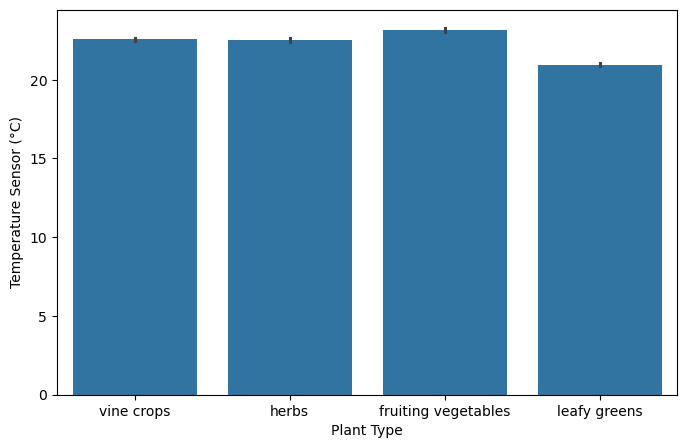

In [14]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 8,5
sns.barplot(x=agri['Plant Type'], y=agri["Temperature Sensor (°C)"], data=agri)
plt.show()

4b. Bar chart to compare mean water level between different Plant Types

Vine crops need a higher water level as compared to the others but fruiting vegetables need the least.

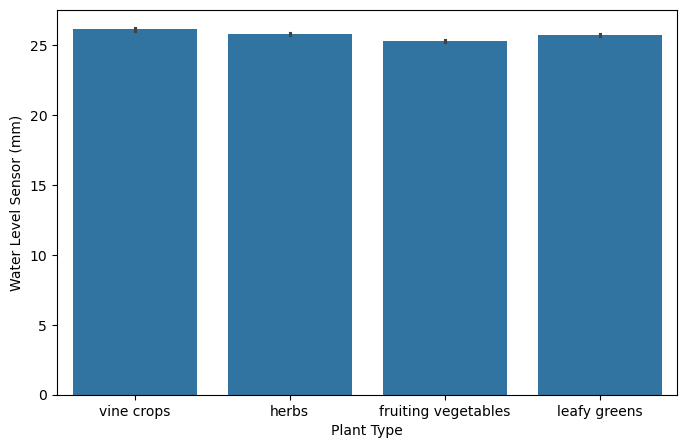

In [15]:
sns.barplot(x=agri['Plant Type'], y=agri["Water Level Sensor (mm)"], data=agri)
plt.show()

4c. Bar chart to compare mean pH level between different Plant Types

Both herbs and fruiting vegetables need a lesser acidic pH as to compared to vine crops which need a more acidic pH

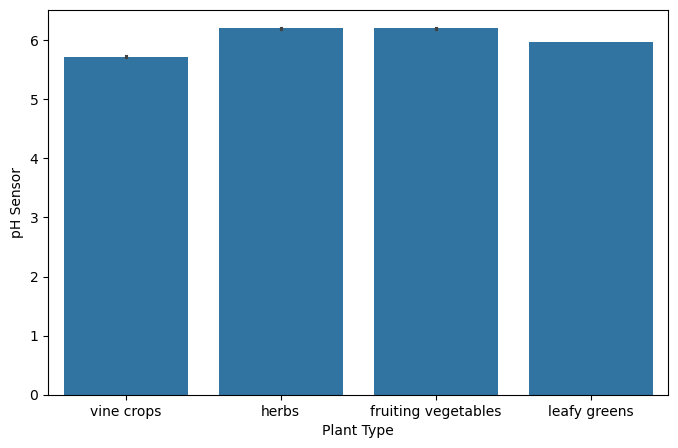

In [16]:
sns.barplot(x=agri['Plant Type'], y=agri["pH Sensor"], data=agri)
plt.show()

4d. Bar chart to compare mean pH level between different Plant Stages

Seeding which is the initial stage requires a more acidic pH as compared to the later stages

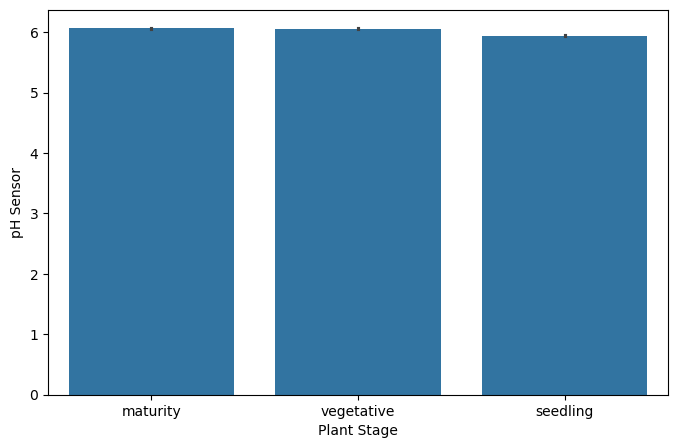

In [17]:
sns.barplot(x=agri['Plant Stage'], y=agri["pH Sensor"], data=agri)
plt.show()